In [1147]:
%load_ext autoreload 
%autoreload 2
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar
from scipy.integrate import cumulative_trapezoid, solve_ivp, solve_bvp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import cmocean


from utility import internal_bore, bore_model, J_boreheight, J_borespeed, J_boremomn

plt.rcParams['figure.dpi'] = 150
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{lmodern}'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Alongshore Currents Generated by Oblique Internal Bores

## Governing Equations: W&H14 Model

From White & Helfrich 2014 (hereafter W&H14) eqn 3.10, the energy flux divergence (equal to the dissipation) of a continuously stratified steady hydrostatic Boussinesq internal bore can be derived from the Bernoulli equation, assuming isopycnals are streamlines.

$$ D = F_x = \int^H_0 C_b(1-\eta_z)\Delta(z)\, dz $$

where $\eta_z$ is the isopycnal displacement, $H$ the water depth, $C_b$ the bore propagation speed, $b(z) = \frac{\rho(z) - \rho(H)}{\rho(0) - \rho(H)} $ the non-dimensional buoyancy, and $\Delta(z)$ is a Bernoulli head loss with an arbitrary vertical structure given by the shape function.

$$\Delta(z) = \Delta_0\big[\frac{1}{2} + \epsilon(b(z) - \frac{1}{2})\big]$$

<!-- Here, we assume $\epsilon = 0$ distributing head loss evenly throughout the water column. -->

W&H14 eqn. 3.2 poses an eigenvalue problem involving the streamline displacement, bore speed, and stratification profile ($\eta$)

$$ \eta_{zz}
+  \frac{N^2(z - \eta)}{C_b^2}\bigg[ \eta 
-  \frac{\Delta_0 \epsilon}{\rho_0 g'} \bigg]
= 0 $$

subject to the boundary conditions $\eta(0) = \eta(H) = 0 $. This can be transformed into a system of first order ODE's; an initial value problem

$$\eta' = \xi$$
$$\xi' = -\frac{N^2(z - \eta)}{C_b^2}\bigg[
\eta -  \frac{\Delta_0 \epsilon}{\rho_0 g'} \bigg]$$

An additional constraint is needed to solve the above which is provided by applying conservation of momentum between the bore and ambient region.

$$ \int^H_0 \big[
\frac{1}{4}\rho_0C_b^2\eta_z^3 - 
(1-\frac{1}{2}\eta_z)\Delta(z)
\big] = 0$$

The above is solved using a nested iterative approach, following White & Helfrich 2014 section 3.6

>The continuous model, (3.4) and (3.7), can be solved by a nested iterative approach
as follows (from the inner- to the outermost levels). (i) Beginning with an initial
value for $\eta_z \equiv \eta'_0$ , a proxy for the bore amplitude, find a value of Cb that satisfies
the eigenvalue problem (3.7) by a shooting method. That is, integrate the ordinary
differential equation (ODE) with initial values $\eta(0) = 0$, $\eta_z(0) = \eta'_0$  iterating on Cb
until the upper boundary condition, $\eta(H) = 0$, is satisfied. (ii) Iterate on $\eta'_0$ until
the bore amplitude, $h_b \equiv \int^H_0 b(z)\,dz$ is equal to the desired value. (iii) Iterate by
varying the head loss constant, $\Delta_0$, until the momentum conservation equation, (3.4),
is satisfied.

## Buoyancy profile

The ambient buoyancy field and its vertical derivative are written as 

$$ b(z) = \frac{1}{2} - \frac{1}{2}\tanh{[\frac{\lambda(z - H_0z_0)}{H_0}]}$$
$$ b'(z) = \frac{\lambda}{2} \text{sech}^2{[\frac{\lambda(z - H_0z_0)}{H_0}]}$$

where $z_0$ is the location of the pycnocline with a thickness $\sim 1/\lambda$ and H_0 is the depth scale for the start of the stratification profile. $\rho(0)$, $\rho(H)$ ,$z_0$, and $\lambda$ were tuned to resemble stratification profiles in McSweeney et al. 2020 JPO Figure 7.

![image](https://journals.ametsoc.org/view/journals/phoc/50/1/full-jpo-d-19-0125.1-f7.jpg)
McSweeney et al. 2020 JPO Figure 7 

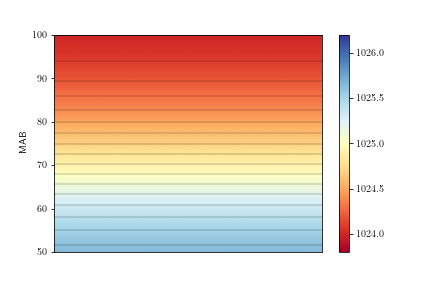

In [951]:
%matplotlib widget
IB = internal_bore(H = 100, H_0 = 100, 𝜆 = 4, z0 = 0.7)

x = np.linspace(0, 10e3, 1000)
h = 0.0*x + 100
s = np.linspace(0,1,100)
Z = np.outer(h,s) 
X = np.outer(x, np.zeros_like(s) + 1)

IB.b, IB.bz = IB.buoyancy(Z)
rho = IB.density()

Zp = Z # - np.outer(h, np.zeros_like(s)+1)

fig, ax = plt.subplots(1)
pc = ax.pcolormesh(X/1e3, Zp, rho, cmap = "RdYlBu", shading = "gouraud", vmin = 1023.8 , vmax = 1026.2)
ax.contour(X/1e3, Zp, rho, np.arange(1024, 1026,0.1), colors = "k", linewidths = 0.25)
plt.colorbar(pc, ax = ax)
ax.set_facecolor("gainsboro")

ax.set_ylabel("MAB")
ax.set_ylim([50,100])
ax.xaxis.set_visible(False)
plt.show()

We find that the parameter choices $H_0 = 100$, $\lambda = 4$, and $z_0 = 0.7$ approximate the observed stratification well. Next, we apply the WH14 model for realistic conditions

In [1174]:
H = 50 #actual depth
h0 = 100 #depth scale
cb = 0.52 #initial propagation speed guess
ib = internal_bore(H = H, H_0 = h0, z0 = 0.7, ε = 0) #, d0 = 1e-5,  ε = -1e-2, rho_s = 1024, rho_b = 1024.1, rho_0 = 1024.05)

In [1175]:
IB = bore_model(h_b = .50*H, ib = ib, cb = cb, disp = True, output = "ib", maxiter = 30) #Solve WH14

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

'dissipation = -5.656...bore amplitude = 19 m'

In [1176]:
ib.bvf() #calculate N2
ib.density(); #calculate dimensional density

We now examine the solutions of the W&H14 model

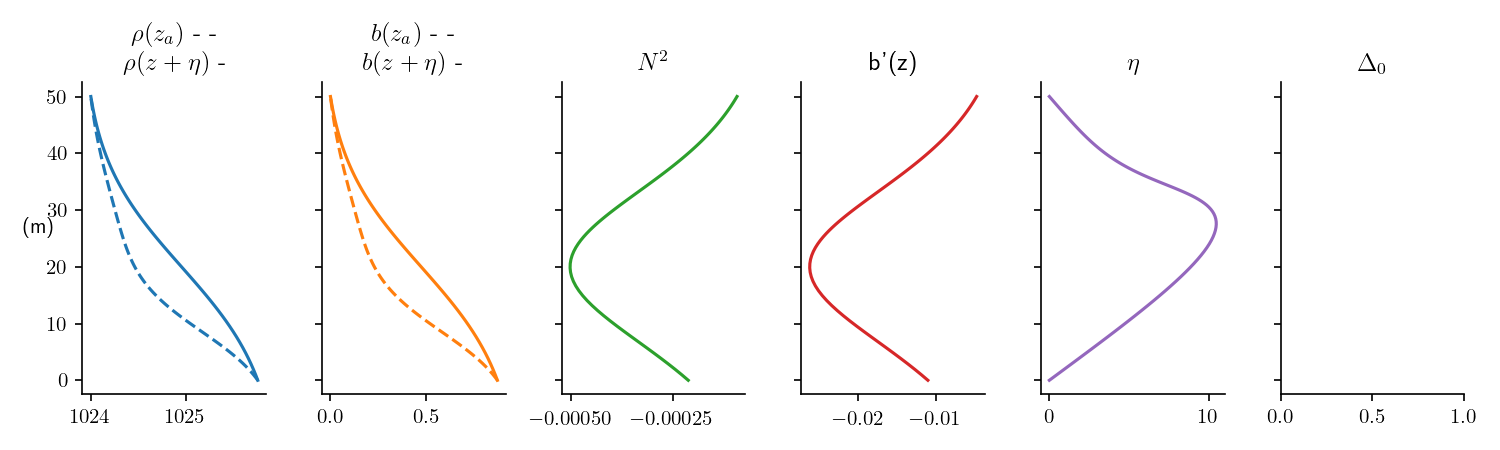

In [1181]:
%matplotlib widget

df = pd.DataFrame(ib.__dict__)

fig, axes = plt.subplots(1,6, figsize = (10,3), sharey = True)
palette = itertools.cycle(sns.color_palette())
for f,ax in zip( ["rho","b","N2","bz","n"], axes.flatten() ):
    c = next(palette)
    sns.lineplot(data = df, x = f, y = "z", color = c, ax = ax, sort = False)
    ax.set_xlabel("")
axes[0].plot(df.rho, df.za, color = sns.color_palette()[0], linestyle = "dashed");
axes[1].plot(df.b, df.za, color = sns.color_palette()[1], linestyle = "dashed");

axes[0].set_ylabel("(m)", rotation = 0)
axes[0].set_title("$\\rho(z_a)$ - - \n $\\rho(z+\eta)$  -")
axes[1].set_title("$b(z_a)$ - - \n $b(z+\eta)$  -")
axes[2].set_title("$N^2$")
axes[3].set_title("b'(z)")
axes[4].set_title("$\eta$")
axes[5].set_title("$\Delta_0$")

sns.despine()
fig.tight_layout()

We can see the bore displaces isopycnals upward and that the boundary conditions $\eta(0)=\eta(H)=0$ are satisfied. We can now use the dissipation calculated by the model for use the alongshore momentum balance

## Alongshore momentum balance

Following LH70, we assume a balance between the stress induced by wave energy flux divergence ($\tau_w$) and the stress due to bottom friction ($\tau_b$)in the alongshore direction ($y$).
Realizing that energy dissipation (D) is equal to the divergence of the energy flux ($\frac{\partial F}{\partial x}$), and invoking Snell’s law, we produce an expression for $\tau_w$

$$\tau_w =  
D\frac{\sin{\theta}}{c_b} $$

where $\theta$ is the incidence angle and $c_b$ the bore propagation speed. The depth-dependent quadratic closure for the alongshore bottom stress is

$$ \tau_b = \rho_0 \frac{C_D}{H} < |\vec{u}| v >  $$

where < > indicates phase-averaging, $H$ is the depth, and $C_D$ is a drag coefficient. After decomposing the velocity into mean and fluctuating components and assuming the bore’s orbital velocity ($u_0$) is much larger than the mean alongshore speed ($v$), the above can be restated as 
$$ \tau_b = \rho_0 \frac{2}{\pi}\frac{C_D u_0 \overline{v}}{H}  $$

Combining the expressions for $\tau_w,\tau_b$ we can solve for the mean alongshore flow speed 
$$ \overline{v} = \frac{\pi}{2} \frac{HD\sin{\theta}}{\rho_0 c_b C_D u_0} $$

We can now estimate $v$ if the internal bore dissipation, bore propagation and orbital speeds, incidence angle, depth, and drag coefficient are known. The oribtal velocity can be computed by rearranging W&H14 eqn 3.10 $D = \int^H_0 U(z) \Delta(z) \, dz$. If $\delta(z)$ is uniform throughout the water column, as is the case for $\epsilon = 0$ the depth-averaged orbital speed can be simply expressed as

$$ \overline{U} = \frac{2D}{H\Delta_0} $$

Using $\overline{U}$ for $u_0$, we arrive at

$$ \overline{v} = \frac{\pi}{4} \frac{\Delta_0\sin{\theta}}{\rho_0 c_b C_D} $$

In [1192]:
def speed(Δ, H = 50, theta = 3.5, Cb = 0.5, Cd = 2.5e-3, rho0 = 1025):
    v = Δ*(np.pi/4)*np.sin(theta*np.pi/180)/(rho0*Cd*Cb)
    return v

In [1193]:
display(f"v = {speed(ib.d0, Cb = 0.32, theta = 3.5):0.2g} m/s")

'v = -0.041 m/s'

$\Delta_0$ is unphysically negative due to unknown issues with my implementation of the W&H14 model, but it is potentially reassuring that the resultant speed is of a reasonable magnitude and compares well with the speed estimated from 

$$ \overline{v} = \frac{\pi}{2} \frac{HD\sin{\theta}}{\rho_0 c_b C_D u_0} $$
$$ \overline{v} \approx 0.05 \, \text{cm/s}$$

using direct field measurements (McSweeney et al. 2020) from which this bore model was inspired.

## References

- Becherer, J., Moum, J. N., Calantoni, J., Colosi, J. A., Barth, J. A., Lerczak, J. A., McSweeney, J. M., MacKinnon, J. A., & Waterhouse, A. F. (2021). Saturation of the Internal Tide over the Inner Continental Shelf. Part I: Observations, Journal of Physical Oceanography, 51(8), 2553-2563. 

- Becherer, J., Moum, J. N., Calantoni, J., Colosi, J. A., Barth, J. A., Lerczak, J. A., McSweeney, J. M., MacKinnon, J. A., & Waterhouse, A. F. (2021). Saturation of the Internal Tide over the Inner Continental Shelf. Part II: Parameterization, Journal of Physical Oceanography, 51(8), 2565-2582.

- Longuet-Higgins, M. S. (1970), Longshore currents generated by obliquely incident sea waves: 1, J. Geophys. Res., 75( 33), 6778– 6789 

- McSweeney, J. M., Lerczak, J. A., Barth, J. A., Becherer, J., MacKinnon, J. A., Waterhouse, A. F., Colosi, J. A., MacMahan, J. H., Feddersen, F., Calantoni, J., Simpson, A., Celona, S., Haller, M. C., & Terrill, E. (2020). Alongshore Variability of Shoaling Internal Bores on the Inner Shelf, Journal of Physical Oceanography, 50(10), 2965-2981. 

- Walter, R. K., Woodson, C. B., Arthur, R. S., Fringer, O. B., and Monismith, S. G. (2012), Nearshore internal bores and turbulent mixing in southern Monterey Bay, J. Geophys. Res., 117, C07017

- White, B., & Helfrich, K. (2014). A model for internal bores in continuous stratification. Journal of Fluid Mechanics, 761, 282-304.

